# Exploration of signals and events

In [1]:
# 79 characters:
# -----------------------------------------------------------------------------
# 72 characters (docstrings or comments):
# ----------------------------------------------------------------------

In [2]:
import pandas as pd
import numpy as np
import random
import datetime
import re
import pickle
import os

import altair as alt
alt.renderers.set_embed_options(theme='dark')

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
# mpl.rcParams['text.color'] = 'white'

from IPython.display import display
pd.options.display.max_columns = None
%xmode Plain

plot_dir = 'out/signals_data'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

read_eios_from_date = pd.Timestamp(2017, 11, 1, 0)

Exception reporting mode: Plain


## Signals list

It doesn't have indications of risk or severity. The (still experimental? or discountinued?) sheet "Activity Tracker" (number of articles read, number of emails received or sent, ...) might be interesting but iz is unclear how it is filed, is not directly relevant and has data only from 1 January 2019 to 1 February 2019.

It doesn't have indications of hazard type (infectious, nuclear, ...) either.

Idea: distinguish between "new" and "update" signals.

In [3]:
signals_table = pd.read_excel('../data/dva_era/DailyLists-20190929-SG.xlsx', 
                              sheet_name='Signals')

In [ ]:
# Remove trailing empty rows
signals_table_corr = signals_table.copy()
signals_table_corr = signals_table_corr.loc[signals_table_corr.DATE.notna(),:]

# Remove blanks from column names
signals_table_corr.columns = signals_table_corr.columns.str.replace(' ', '')

# Clean types
int_cols = ['ID','DailyDVAList','DailyDG','DailyWHEDAEMM','InEMS','RegionID',
            'CountryID','SourceTypeID']
select_int_cols = signals_table_corr.columns.isin(int_cols)
signals_table_corr.loc[:,select_int_cols] = (
    signals_table_corr.loc[:,select_int_cols].astype('Int64')
)
date_cols = ['DATE','ShowFrom','ShowTo']
for col in date_cols:
    isnot_date = [(type(dat) is not datetime.datetime) 
                  & (type(dat) is not pd.Timestamp) 
                  for dat in signals_table_corr.loc[:,col]]
    signals_table_corr.loc[isnot_date,col] = np.nan

select_date_cols = signals_table_corr.columns.isin(date_cols)
signals_table_corr.loc[:,select_date_cols] = (signals_table_corr
                                              .loc[:,select_date_cols]
                                              .astype('datetime64[ns]'))

str_cols = signals_table_corr.columns[
    ~signals_table_corr.columns.isin(int_cols+date_cols)
]
select_str_cols = signals_table_corr.columns.isin(str_cols)
signals_table_corr.loc[:,select_str_cols] = (
    signals_table_corr.loc[:,select_str_cols].astype(str)
)

# Try and remove some disease and country duplicates by setting lower
# case and removing spaces
signals_table_corr['disease'] = (signals_table_corr['Disease-Condition']
                                 .astype(str)
                                 .str.lower()
                                 .str.replace(' ',''))
signals_table_corr['country'] = (signals_table_corr['CountryAffected']
                                 .astype(str)
                                 .str.lower()
                                 .str.replace(' ',''))

signals_table_corr.reindex()

# Keep only signals after first article in the EIOS dataset
signals_table_corr = signals_table_corr.loc[signals_table_corr.DATE >= read_eios_from_date]

display(signals_table_corr.tail())

### Diseases

In [5]:
disease_count = signals_table_corr['disease'].value_counts().to_frame() 
disease_count.reset_index(inplace=True)
disease_count.rename(columns = {'index':'disease','disease':'count'}, 
                     inplace=True)
print(disease_count.head(10))
print('number of diseases =', disease_count.shape[0])

              disease  count
0             measles    138
1             cholera    132
2              dengue     87
3         yellowfever     79
4  undiagnoseddisease     55
5          lassafever     43
6             malaria     35
7     riftvalleyfever     35
8            mers-cov     33
9          diphtheria     32
number of diseases = 313


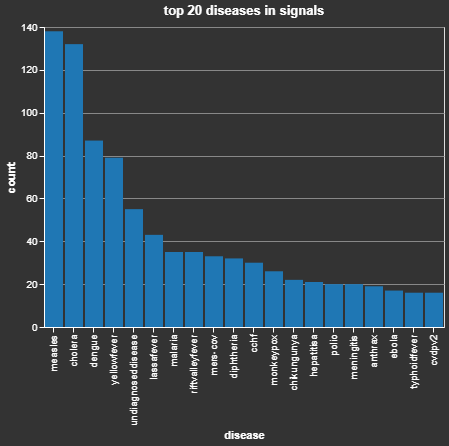

In [6]:
highlight = alt.selection(type = 'single', on = 'mouseover', 
                          fields = ['disease'])
disease_count_plot = alt.Chart(disease_count.iloc[0:20],
                               title = 'top 20 diseases in signals').mark_bar().encode(
    x = alt.Y('disease', sort = None),
    y = 'count',
    tooltip = ['disease', 'count'],
    color = alt.condition(~highlight, alt.value('#1f77b4'), 
                          alt.value('#aec7e8'))
).add_selection(
    highlight
)
display(disease_count_plot)
disease_count_plot.save(plot_dir+'/signals_disease_count.html')

### Countries

In [7]:
country_count = signals_table_corr['country'].value_counts().to_frame() 
country_count.reset_index(inplace=True)
country_count.rename(columns = {'index':'country', 'country':'count'}, 
                     inplace=True)
print(country_count.head(10))
print('number of countries =', country_count.shape[0])

                             country  count
0                            nigeria     82
1                             uganda     63
2  democraticrepublicofthecongo(the)     58
3                              india     54
4                             brazil     49
5                           pakistan     42
6                              kenya     40
7         unitedstatesofamerica(the)     37
8                              china     31
9                        saudiarabia     27
number of countries = 182


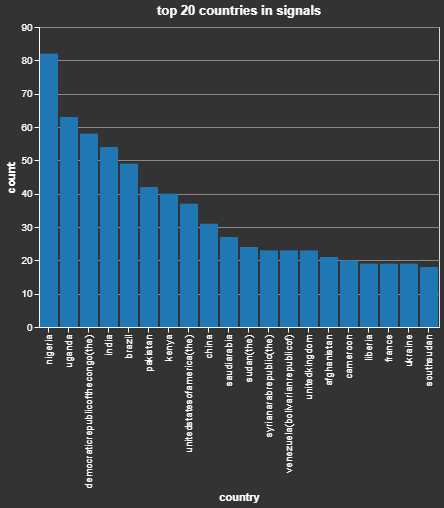

In [8]:
highlight = alt.selection(type = 'single', on = 'mouseover', 
                          fields = ['country'])
country_count_plot = alt.Chart(country_count.iloc[0:20],
                               title = 'top 20 countries in signals').mark_bar().encode(
    x = alt.Y('country', sort = None),
    y = 'count',
    tooltip = ['country', 'count'],
    color = alt.condition(~highlight, alt.value('#1f77b4'),
                          alt.value('#aec7e8'))
).add_selection(
    highlight
)
display(country_count_plot)
country_count_plot.save(plot_dir+'/signals_country_count.html')

### Dates

In [9]:
# day
signals_table_corr['DATE_day'] = signals_table_corr['DATE']
signals_table_corr.loc[signals_table_corr.DATE.notna(),'DATE_day'] = [
    datetime.datetime(dat.year, dat.month, dat.day) 
    for dat in signals_table_corr.DATE if pd.notna(dat)
]
signals_day_count = (signals_table_corr.DATE_day
                     .loc[signals_table_corr.DATE_day.notna()]
                     .value_counts().to_frame())
idx_day = pd.date_range(min(signals_day_count.index.values),
                        max(signals_day_count.index.values))
signals_day_count = signals_day_count.reindex(idx_day, fill_value = 0)
signals_day_count.index.name = 'date'
signals_day_count.reset_index(inplace=True)
signals_day_count.rename(columns = {'date':'date', 'DATE_day':'mult'},
                         inplace=True)

# week
signals_table_corr['DATE_week'] = signals_table_corr['DATE']
signals_table_corr.loc[signals_table_corr.DATE.notna(),'DATE_week'] = [
    pd.to_datetime(str(dat.year)+'-'+str(dat.week)+'-1',format = '%Y-%W-%w')
    for dat in signals_table_corr.DATE if pd.notna(dat)
]
signals_week_count = signals_table_corr.DATE_week.value_counts().to_frame() 
idx_week = pd.date_range(min(signals_week_count.index.values), 
                         max(signals_week_count.index.values), 
                         freq='7D')
signals_week_count = signals_week_count.reindex(idx_week, fill_value=0)
signals_week_count.index.name = 'date'
signals_week_count.reset_index(inplace=True)
signals_week_count.rename(columns = {'date':'date', 'DATE_week':'mult'},
                          inplace=True)

# month
signals_table_corr['DATE_month'] = signals_table_corr['DATE']
signals_table_corr.loc[signals_table_corr.DATE.notna(),'DATE_month'] = [
    datetime.datetime(dat.year, dat.month, 1) 
    for dat in signals_table_corr.DATE if pd.notna(dat)
]
signals_month_count = signals_table_corr.DATE_month.value_counts().to_frame() 
idx_month = pd.date_range(min(signals_month_count.index.values),
                          max(signals_month_count.index.values),
                          freq='MS')
signals_month_count = signals_month_count.reindex(idx_month, fill_value=0)
signals_month_count.index.name = 'date'
signals_month_count.reset_index(inplace=True)
signals_month_count.rename(columns = {'date':'date', 'DATE_month':'mult'},
                           inplace=True)

In [10]:
# week and disease
most_common_diseases = disease_count.head(10).disease
signals_week_disease_count = (
    signals_table_corr.loc[
        signals_table_corr.disease.isin(most_common_diseases) 
        & signals_table_corr.DATE_week.notnull(),
        ['DATE_week','disease']]
    .copy()
)
signals_week_disease_count.set_index(['DATE_week','disease'], inplace=True)
signals_week_disease_count = (signals_week_disease_count
                              .groupby(['DATE_week','disease'])
                              .size())

idx_wd_date = [i[0] for i in signals_week_disease_count.index]
idx_wd_date = pd.date_range(min(idx_wd_date), max(idx_wd_date), freq='7D')

signals_week_disease_count = (
    signals_week_disease_count.reindex(
        pd.MultiIndex.from_product((idx_wd_date, most_common_diseases)),
        fill_value = 0)
)
signals_week_disease_count = signals_week_disease_count.to_frame()
signals_week_disease_count.index.names = ['date','disease']
signals_week_disease_count.columns = ['count']
signals_week_disease_count.reset_index(inplace = True)

In [11]:
# week and country
most_common_countries = country_count.head(10).country
signals_week_country_count = (
    signals_table_corr.loc[
        signals_table_corr.country.isin(most_common_countries) 
        & signals_table_corr.DATE_week.notnull(),
        ['DATE_week','country']]
    .copy()
)
signals_week_country_count.set_index(['DATE_week','country'], inplace=True)
signals_week_country_count = (signals_week_country_count
                              .groupby(['DATE_week','country'])
                              .size())

idx_wd_date = [i[0] for i in signals_week_country_count.index]
idx_wd_date = pd.date_range(min(idx_wd_date), max(idx_wd_date), freq='7D')

signals_week_country_count = (
    signals_week_country_count.reindex(
        pd.MultiIndex.from_product((idx_wd_date, most_common_countries)),
        fill_value = 0)
)
signals_week_country_count = signals_week_country_count.to_frame()
signals_week_country_count.index.names = ['date','country']
signals_week_country_count.columns = ['count']
signals_week_country_count.reset_index(inplace = True)

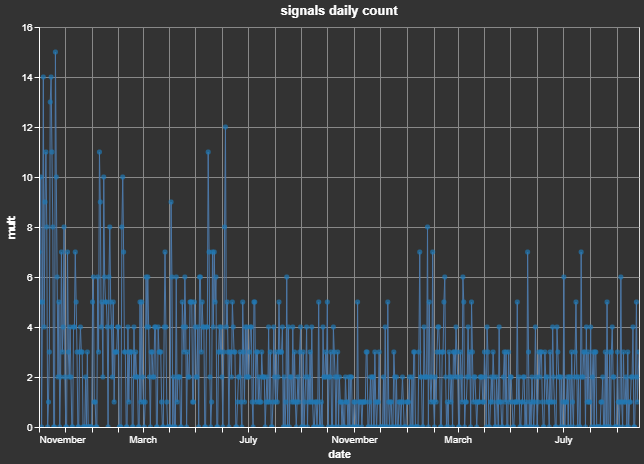

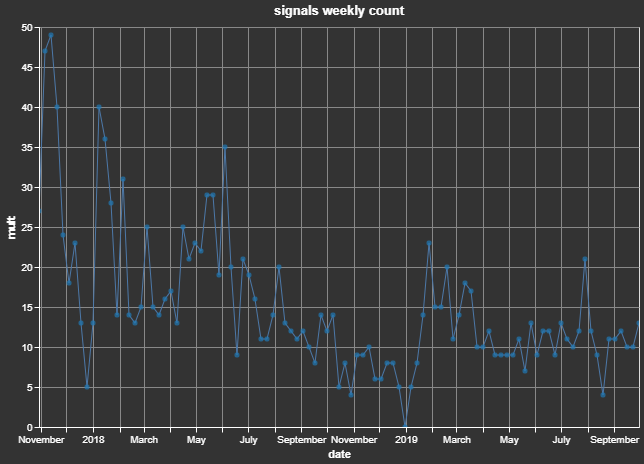

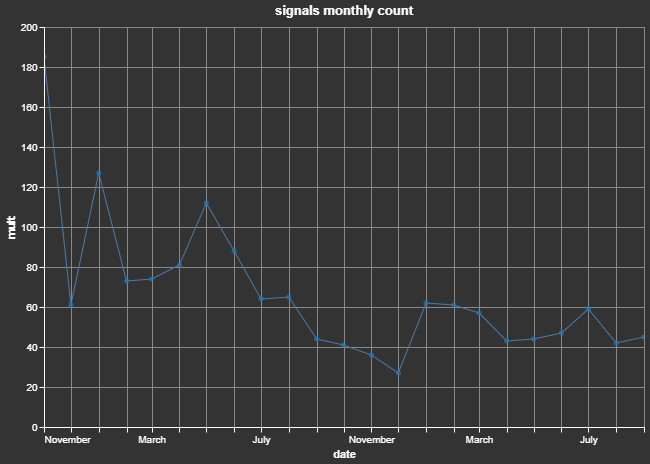

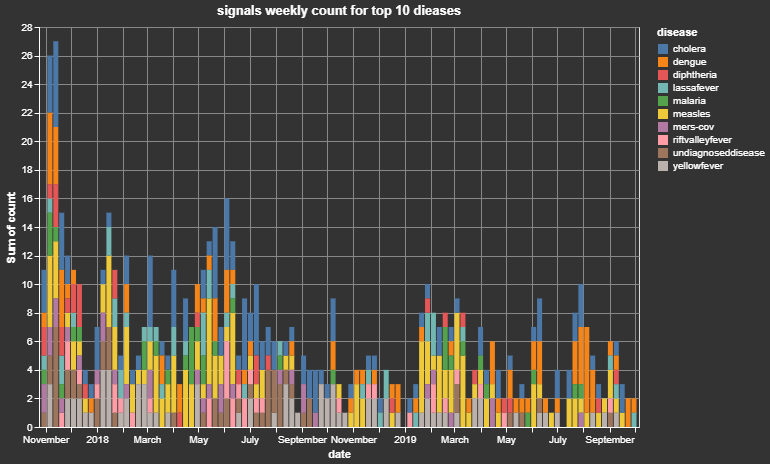

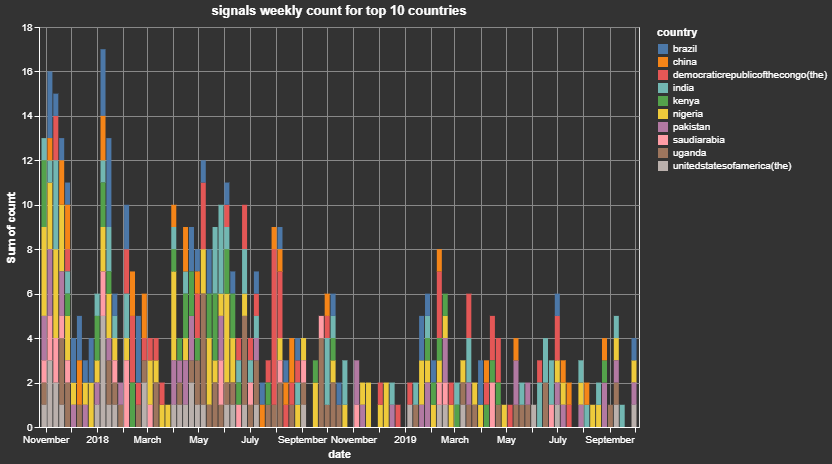

In [12]:
# Plots
highlight = alt.selection(type = 'single', on = 'mouseover', fields = ['date'])

# day
signals_day_count_plot_line = (
    alt.Chart(signals_day_count)
    .mark_line(size = 1)
    .encode(
        x = alt.Y('date', sort = None),
        y = 'mult'
    )
)
signals_day_count_plot_points = (
    alt.Chart(signals_day_count, title = 'signals daily count')
    .mark_circle(size = 25)
    .encode(
        x = alt.Y('date', sort = None),
        y = 'mult',
        tooltip = ['date', 'mult'],
        color = alt.condition(~highlight, alt.value('#1f77b4'),
                              alt.value('#aec7e8'))
    ).add_selection(
        highlight
    )
)
signals_day_count_plot = ((signals_day_count_plot_line
                           + signals_day_count_plot_points)
                          .interactive(bind_y = False)
                          .properties(height = 400, width = 600))
display(signals_day_count_plot)
signals_day_count_plot.save(plot_dir+'/signals_day_count.html')

# week
signals_week_count_plot_line = (
    alt.Chart(signals_week_count)
    .mark_line(size = 1)
    .encode(
        x = alt.Y('date', sort = None),
        y = 'mult'
    )
)
signals_week_count_plot_points = (
    alt.Chart(signals_week_count, title = 'signals weekly count')
    .mark_circle(size = 25)
    .encode(
        x = alt.Y('date', sort = None),
        y = 'mult',
        tooltip = ['date', 'mult'],
        color = alt.condition(~highlight, alt.value('#1f77b4'),
                              alt.value('#aec7e8'))
    ).add_selection(
        highlight
    )
)
signals_week_count_plot = ((signals_week_count_plot_line
                            + signals_week_count_plot_points)
                           .interactive(bind_y = False)
                           .properties(height = 400, width = 600))
display(signals_week_count_plot)
signals_week_count_plot.save(plot_dir+'/signals_week_count.html')

# month
signals_month_count_plot_line = (
    alt.Chart(signals_month_count)
    .mark_line(size = 1)
    .encode(
        x = alt.Y('date', sort = None),
        y = 'mult'
    )
)
signals_month_count_plot_points = (
    alt.Chart(signals_month_count, title = 'signals monthly count')
    .mark_circle(size = 25)
    .encode(
        x = alt.Y('date', sort = None),
        y = 'mult',
        tooltip = ['date', 'mult'],
        color = alt.condition(~highlight, alt.value('#1f77b4'),
                              alt.value('#aec7e8'))
    ).add_selection(
        highlight
    )
)
signals_month_count_plot = ((signals_month_count_plot_line
                             + signals_month_count_plot_points)
                            .interactive(bind_y = False)
                            .properties(height = 400, width = 600))
display(signals_month_count_plot)
signals_month_count_plot.save(plot_dir+'/signals_month_count.html')

# week and disease
signals_week_disease_count_plot = (
    alt.Chart(signals_week_disease_count,
              title = 'signals weekly count for top 10 dieases')
    .mark_bar()
    .encode(
        x = 'date',
        y = 'sum(count)',
        color = 'disease', 
        tooltip = ['date', 'disease', 'count']
    ).interactive(
        bind_y = False
    ).properties(height = 400, width = 600)
)
display(signals_week_disease_count_plot)
signals_week_disease_count_plot.save(plot_dir+'/signals_week_disease_count.html')

# week and country
signals_week_country_count_plot = (
    alt.Chart(signals_week_country_count,
              title = 'signals weekly count for top 10 countries')
    .mark_bar()
    .encode(
        x = 'date',
        y = 'sum(count)',
        color = 'country', 
        tooltip = ['date', 'country', 'count']
    ).interactive(
        bind_y = False
    ).properties(height = 400, width = 600)
)
display(signals_week_country_count_plot)
signals_week_country_count_plot.save(plot_dir+'/signals_week_country_count.html')

### Sources

EMS on the one hand, media and other online sources on the other.

In [32]:
#         link_list = [y.strip().strip(strip_lead_trail).strip() 
#                      for sublist in [x.split(charsplit) for x in link_list]
#                      for y in sublist]
#         link_list_media = [l for l in link_list
#                           if (all(sep in l for sep in ['.','/']) 
#                               & (len(l) >= 5)
#                               & all([intern not in l 
#                                     for intern in ['who.int','?eid=']]))]


# EMS
signals_idx_ems_inems = signals_table_corr.index[signals_table_corr.InEMS == 1]
signals_idx_ems_link1 = signals_table_corr.index[
    signals_table_corr.Weblink.notna()
    & signals_table_corr.Weblink.str.contains('ems.who.int', regex=False)
]
signals_idx_ems_link2 = signals_table_corr.index[
    signals_table_corr.Weblink.notna()
    & signals_table_corr.Weblink.str.contains('?eid=', regex=False)
]
signals_idx_ems_source = signals_table_corr.index[
    signals_table_corr.SOURCE.notna()
    & signals_table_corr.SOURCE.str.contains('EMS')
]

# Media and other online public sources that are potentially in EIOS
media_tags_include = ['bulletin','gphin','healthmap','healtmap','media','news',
                      'official','press','promed','pubmed','reliefweb',
                      'statement','update']
media_tags_exclude = ['internal','personal','private']

signals_idx_media_source = signals_table_corr.index[
    signals_table_corr.SOURCE.notna()
    & signals_table_corr.SOURCE.str.contains('|'.join(media_tags_include),
                                             case=False)
    & ~signals_table_corr.SOURCE.str.contains('|'.join(media_tags_exclude),
                                              case=False)]

signals_idx_media_link = signals_table_corr.index[
    signals_table_corr.Weblink.notna()
    & signals_table_corr.Weblink.str.contains('http|www|htm')
    & signals_table_corr.Weblink.str.contains('.')
    & signals_table_corr.Weblink.str.contains('/')
    & (~signals_table_corr.Weblink.str.contains('who.int|\?eid=') 
       | signals_table_corr.Weblink.str.contains('media', case=False)
       | (signals_table_corr.Weblink.str.count('http|www|htm') > 1))]

In [33]:
# Choose between, or combine, ems_link1 and ems_link2 
print('Links containing "ems.who.int" but not "?eid="') 
print(*signals_table_corr.loc[
          signals_idx_ems_link1[
              ~signals_idx_ems_link1.isin(
                  signals_idx_ems_link2
              )],
          'Weblink'], 
      sep = '// \n')
print()
print('Links containing "?eid=" but not "ems.who.int"') 
print(*signals_table_corr.loc[
          signals_idx_ems_link2[
              ~signals_idx_ems_link2.isin(
                  signals_idx_ems_link1
              )],
          'Weblink'], 
      sep = '// \n')
print()
print('So we\'ll use "?eid=" to identify EMS links.')

Links containing "ems.who.int" but not "?eid="
http://ems.who.int/summary/summaryCountry.aspx?countryID=36

Links containing "?eid=" but not "ems.who.int"
http://www.newtimes.co.rw/news/rift-valley-fever-disease-now-reported-kamonyi-district                                                                               http://ems/Event/eventSummary.aspx?eid=2018-E000254 // 
http://ems/Event/eventSummary.aspx?eid=2018-E000210 // 
http://ems/Event/eventSummary.aspx?eid=2018-E000288// 
http://ems/Event/eventSummary.aspx?eid=2018-E000287// 
http://ems/Event/eventSummary.aspx?eid=2018-E000290// 
http://ems/Event/eventSummary.aspx?eid=2018-E000187 // 
http://ems/Event/eventSummary.aspx?eid=2018-E000253 // 
http://ems/Event/eventSummary.aspx?eid=2018-E000210 // 
http://ems/Event/eventSummary.aspx?eid=2018-E000284 // 
http://ems/Event/eventSummary.aspx?eid=2018-E000432 

So we'll use "?eid=" to identify EMS links.


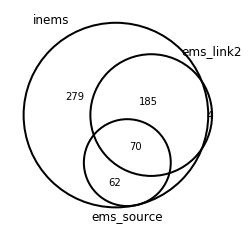

In [34]:
# Venn diagram of media_source, media_link, ems_link2
venn_media_ems = venn3([set(signals_idx_ems_inems), 
                        set(signals_idx_ems_link2), 
                        set(signals_idx_ems_source)], 
                       ('inems', 'ems_link2', 'ems_source'), alpha = 0)
venn_circles_media_ems = venn3_circles([set(signals_idx_ems_inems),
                                        set(signals_idx_ems_link2),
                                        set(signals_idx_ems_source)], 
                                       color = 'black')
plt.savefig(plot_dir + '/signals_media_ems-1.pdf')

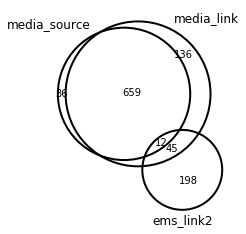

In [35]:
# Venn diagram of media_source, media_link, ems_link2
venn_media_ems = venn3([set(signals_idx_media_source), 
                        set(signals_idx_media_link), 
                        set(signals_idx_ems_link2)], 
                       ('media_source', 'media_link', 'ems_link2'), alpha = 0)
venn_circles_media_ems = venn3_circles([set(signals_idx_media_source),
                                        set(signals_idx_media_link),
                                        set(signals_idx_ems_link2)], 
                                       color = 'black')
plt.savefig(plot_dir + '/signals_media_ems-2.pdf')

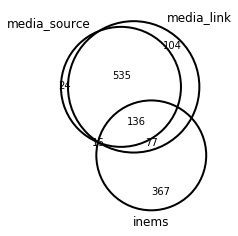

In [36]:
# Venn diagram of media_source, media_link, inems
venn_media_ems = venn3([set(signals_idx_media_source), 
                        set(signals_idx_media_link), 
                        set(signals_idx_ems_inems)], 
                       ('media_source', 'media_link', 'inems'), alpha = 0)
venn_circles_media_ems = venn3_circles([set(signals_idx_media_source),
                                        set(signals_idx_media_link),
                                        set(signals_idx_ems_inems)], 
                                       color = 'black')
plt.savefig(plot_dir + '/signals_media_ems-3.pdf')

In [18]:
# Distribution of media sources
# Heuristic to find individual links: Split Weblink along " ", then split 
# along noninfo_substr. A valid media link will contain both a "." and a 
# "/", be at least five characters long, and don't contain "ems.who.int"
# or "?eid=".
# Leading and trailing undesired characters, including regex special
# characters, are then removed.
noninfo_substr = ['http://','https://','www.','www2.','wwwnc.']
strip_lead_trail = ' /,;.?!<>\r\n'

signals_media_links = pd.DataFrame(columns=['url','date','disease','country','event_id'])
media_sites = []
for i in signals_idx_media_link:
# for link_list in signals_media_links:
    link_date = signals_table_corr.DATE[i]
    link_list = signals_table_corr.Weblink[i].split(' ')
#     link_disease = signals_table_corr.disease[i]
    link_disease = signals_table_corr.loc[i,'Disease-Condition']
#     link_country = signals_table_corr.country[i]
    link_country = signals_table_corr.loc[i,'CountryAffected']
    # Further split concatanated URLs and remove non-informative
    # substrings
    for charsplit in noninfo_substr:
        # Separate URLs.
        # Remove leading or trailing escaped characters, 
        # whitspaces or punctuation. Just to be sure, also
        # apply .strip() twice to remove special characters
        # that might not be in strip_lead_trail
        link_list = [y.strip().strip(strip_lead_trail).strip() 
                     for sublist in [x.split(charsplit) for x in link_list]
                     for y in sublist]
        link_list_media = [l for l in link_list
                          if (all(sep in l for sep in ['.','/']) 
                              & (len(l) >= 5)
                              & all([intern not in l 
                                    for intern in ['who.int','?eid=']]))]
        link_list_ems = [l for l in link_list if '?eid=' in l]
    if len(link_list_media) > 0:
        for unique_link in link_list_media:
            if len(link_list_ems) > 0:
                for ems_link in link_list_ems:
                    ems_id = ems_link.split('?eid=')[-1].split('&')[0].split('\n')[0]
                signals_media_links = (
                    signals_media_links.append(
                        {'url':unique_link, 'date':link_date,
                         'disease':link_disease, 'country':link_country,
                         'event_id':ems_id}, 
                        ignore_index=True))
            else:
                signals_media_links = (
                    signals_media_links.append(
                        {'url':unique_link, 'date':link_date,
                         'disease':link_disease, 'country':link_country,
                         'event_id':None}, 
                        ignore_index=True))
            
            unique_site = unique_link.split('/')[0]
            if len(unique_site) > 0:
                media_sites.append(unique_site)

display(signals_media_links.head())

,url,date,disease,country,event_id
0,promedmail.org/direct.php?id=20171031.5416115,2017-11-01,Cholera,Kenya,None
1,thenationonlineng.net/monkeypox-hits-edo,2017-11-01,Monkeypox,Nigeria,None
2,moh.gov.sa/en/CCC/PressReleases/Pages/default....,2017-11-01,MERS-CoV,Saudi Arabia,None
3,promedmail.org/direct.php?id=20171031.5417235,2017-11-01,Rabies,United States of America (the),None
4,citizentv.co.ke/news/marburg-alert-four-people...,2017-11-01,Marburg,Kenya,None


In [19]:
# Save unique links
pickle.dump(signals_media_links,
            open('pickles/signals_data.pickle', 'wb'))

In [20]:
# Count media sources
media_sites_count = pd.Series(media_sites).value_counts().to_frame()
media_sites_count.reset_index(inplace = True)
media_sites_count.rename(columns = {'index':'source', 0:'count'}, inplace=True)
print(media_sites_count.head(10))
print('number of media sources =', media_sites_count.shape[0])

                        source  count
0               promedmail.org    118
1                reliefweb.int     25
2        outbreaknewstoday.com     15
3                  ncdc.gov.ng     14
4                   moh.gov.sa     14
5                xinhuanet.com     13
6                 g1.globo.com     11
7  timesofindia.indiatimes.com     11
8                  info.gov.hk      9
9         polioeradication.org      9
number of media sources = 520


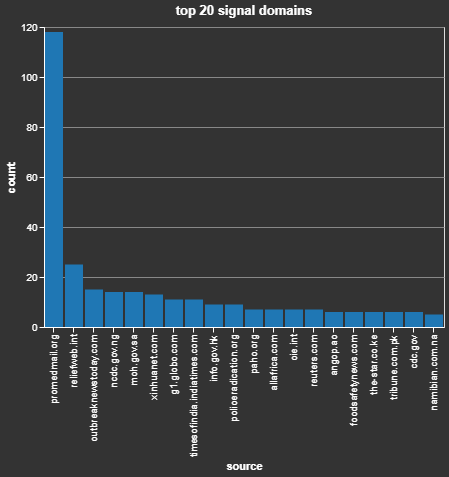

In [21]:
highlight = alt.selection(type = 'single', on = 'mouseover',
                          fields = ['source'])
media_sites_count_plot = alt.Chart(media_sites_count.iloc[0:20],
                                   title = 'top 20 signal domains').mark_bar().encode(
    x = alt.Y('source', sort = None),
    y = 'count',
    tooltip = ['source', 'count'],
    color = alt.condition(~highlight, alt.value('#1f77b4'),
                          alt.value('#aec7e8'))
).add_selection(
    highlight
)
display(media_sites_count_plot)
media_sites_count_plot.save(plot_dir+'/signals_media_sites_count.html')

## Signals Ebola

In [22]:
ebola_table = pd.read_excel(
    '../data/dva_era/Updated Ebola alert tracker_new-20190929-SG.xlsx', 
    sheet_name = 'Alerts')

In [ ]:
print(ebola_table.shape,'\n\n')
display(ebola_table.tail())
print(*ebola_table.columns, sep='; ')

In [24]:
ebola_media_links = pd.DataFrame(columns=['url','date','disease','country','event_id'])
ebola_idx_media_link = ebola_table[
    [url != 'nan' for url in ebola_table.Weblink.astype(str)]
].index
for i in ebola_idx_media_link:
# for link_list in signals_media_links:
    link_date = ebola_table.loc[i,'Date Open']
    if type(link_date) is str:
        link_date = [int(da) for da in link_date.split('/')]
        if link_date[2] == 209:
            link_date[2] = 2019
        link_date = datetime.datetime(link_date[2],link_date[1],link_date[0])
    elif type(link_date) == float:
        link_date = np.nan
    link_list = ebola_table.Weblink[i].split(' ')
    link_disease = 'Ebola'
    link_country = ebola_table.Country[i]
    # Further split concatanated URLs and remove non-informative
    # substrings.
    # N.B. Ebola alerts don't have EMS event IDs
    for charsplit in noninfo_substr:
        # Remove leading or trailing escaped characters, 
        # whitspaces or punctuation. Just to be sure, also
        # apply .strip() twice to remove special characters
        # that might not be in strip_lead_trail
        link_list = [y.strip().strip(strip_lead_trail).strip() 
                     for sublist in [x.split(charsplit) for x in link_list]
                     for y in sublist]
        link_list_media = [l for l in link_list
                          if (all(sep in l for sep in ['.','/']) 
                              & (len(l) >= 5)
                              & all([intern not in l 
                                    for intern in ['who.int','?eid=']]))]
    if len(link_list_media) > 0:
        for unique_link in link_list_media:
            ebola_media_links = (
                ebola_media_links.append(
                    {'url':unique_link, 'date':link_date,
                     'disease':link_disease, 'country':link_country,
                     'event_id':None}, 
                    ignore_index=True))
print(ebola_media_links.shape)
display(ebola_media_links.head())

(28, 5)


,url,date,disease,country,event_id
0,observer.ug/news/headlines/58281-strange-disea...,NaT,Ebola,Uganda,None
1,observer.ug/news/headlines/58281-strange-disea...,NaT,Ebola,Uganda,None
2,observer.ug/news/headlines/58281-strange-disea...,NaT,Ebola,Uganda,None
3,observer.ug/news/headlines/58281-strange-disea...,NaT,Ebola,Uganda,None
4,observer.ug/news/headlines/58281-strange-disea...,NaT,Ebola,Uganda,None


In [25]:
# Save Ebola links
pickle.dump(ebola_media_links,
            open('pickles/ebola_alerts_data.pickle', 'wb'))

## EMS data

Instead of trying to query the EMS databases, we will work with the export possibilities offered by the platform. For conveniance but also because the export didn't work for longer time ranges, we will work for the moment with events created between **1 July 2018 and 31 August 2018.** 

### List of events from the Events page
 
The list was exported from the "all events" tab with the "All variables" template as a CSV file. To XML formats are also available (simple and Excel Worksheet) but they don't bring anything as the variables are not nested and the types are always given as "String".

A data model of sorts is provided as an HTML table: *../data/ems/EMS-all_variables_template-datamodel.html*

Selecting manually all variables to be exported results in somewhat more variables (about 168 instead of 152 here), but the export didn't work.

In [ ]:
ems_list_main = pd.read_csv(
    '../data/ems/EMS-all_variables_template-20180701-20180831.csv')
print(ems_list_main.shape)
display(ems_list_main.head())
# print(*ems_list_main.columns,sep='; ')

### List of events from the Reports page

The dedicated Reports page "EMS Data Export" offers three tables.

In [ ]:
ems_list_export_1 = pd.read_excel(
    '../data/ems/EMS-Data_TableView1-20180701-20180831.xls')
ems_list_export_2 = pd.read_excel(
    '../data/ems/EMS-Data_TableView2-20180701-20180831.xls')
ems_list_export_3 = pd.read_excel(
    '../data/ems/EMS-Data_TableView3-20180701-20180831.xls')

print(ems_list_export_1.shape)
display(ems_list_export_1.head())
print(*ems_list_export_1.columns, sep='; ')
print('\n\n')
print(ems_list_export_2.shape)
display(ems_list_export_2.head())
print(*ems_list_export_2.columns, sep='; ')
print('\n\n')
print(ems_list_export_3.shape)
display(ems_list_export_3.head())
print(*ems_list_export_3.columns, sep='; ')

### Risk assessments

More information on the Rapid Risk Assessment itself can be downloaded from the corresponding report "Overview of Rapid Risk Assessments".

In [ ]:
ems_rra = pd.read_excel(
    '../data/ems/EMS-RapidRiskAssessment_TableView1-20180701-20180831.xls')
print(ems_rra.shape)
display(ems_rra.head())
print(*ems_rra.columns, sep='; ')

## Final EMS data set

The Table2 from EMS Data has the most information, we'll work with it.

In [ ]:
ems_data_raw = pd.read_excel(
    '../data/ems/EMS-Data_TableView2-20171001-20190930_20191001.xls')
print(ems_data_raw.shape)
display(ems_data_raw.head())

In [ ]:
# Simplify and arrange
date_from = [min(ems_data_raw.loc[i,'Date Information First Received'],
                 ems_data_raw.loc[i,'Date Created'],
                 ems_data_raw.loc[i,'Estimated Date of Onset'])
             for i in range(ems_data_raw.shape[0])]
date_to = [min(ems_data_raw.loc[i,'Last Updated'],
               ems_data_raw.loc[i,'Designation Date'],
               ems_data_raw.loc[i,'Last Verification Request Sent on'],
               ems_data_raw.loc[i,'RRAFinalizedDate'])
             for i in range(ems_data_raw.shape[0])]
source_media = [int('media' in ems_data_raw.loc[i,'Source Type'].lower()) 
                for i in range(ems_data_raw.shape[0])]
ems_data = pd.DataFrame({
    'event_id':ems_data_raw['Event link'],
    'date_from':date_from,
    'date_to':date_to,
    'disease':ems_data_raw['Disease or Condition'],
    'country':ems_data_raw['Country or Area'],
    'media':source_media,
    'ihr_assessment':ems_data_raw['IHR Assessment'],
    'serious_ph':ems_data_raw['Serious Public Health Impact (WHO)'],
    'unusual_unexpected':ems_data_raw['Unusual or Unexpected (WHO)'],
    'international_spread':ems_data_raw['International Disease Spread (WHO)'],
    'travel_trade':ems_data_raw['Interference with international travel or trade (WHO)'],
    'rra_national':ems_data_raw['RRANationalRiskLevel'],
    'rra_regional':ems_data_raw['RRARegionalRiskLevel'],
    'rra_global':ems_data_raw['RRAGlobalRiskLevel']
})
print(ems_data.shape)
print(len(ems_data.event_id.unique()))
print_stats = [col for col in ems_data.columns if not col in ['event_id','date_from','date_to']]
for col in print_stats:
    print('-----', col, ems_data[col].value_counts(dropna=False).to_frame())
    
# print('-----Source = media:', sum(ems_data.media))
# print('-----IHR Assessment:', ems_data.ihr_assessment.value_counts(dropna=False).to_frame())
# print('-----Serious...:', ems_data.serious_ph.value_counts(dropna=False).to_frame())
# print('-----Unusual...:', ems_data.unusual_unexpected.value_counts(dropna=False).to_frame())
# print('-----Spread...:', ems_data.international_spread.value_counts(dropna=False).to_frame())
# print('-----Travel...:', ems_data.travel_trade.value_counts(dropna=False).to_frame())
# print('-----RRA national:', ems_data.rra_national.value_counts(dropna=False).to_frame())
# print('-----RRA regional:', ems_data.rra_regional.value_counts(dropna=False).to_frame())
# print('-----RRA global:', ems_data.rra_global.value_counts(dropna=False).to_frame())
display(ems_data.head())
display(ems_data_raw[['Disease or Condition','Aetiology',
                      'Syndrome','Hazard']]
        [[type(di) == float for di in ems_data_raw['Disease or Condition']]])

In [31]:
# Save Ebola links
pickle.dump(ems_data,
            open('pickles/ems_data.pickle', 'wb'))